In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
from joblib import (Parallel,
                    delayed)
from qiskit_algorithms.optimizers import SPSA

from src.Tools import portfolio_metrics
from qiskit_src.ansatz import CP_QAOA
from qiskit_src.tools import get_qubo, min_cost_partition, normalized_cost

In [2]:
plt.rc("font", family=["Helvetica", "Arial"])
plt.rc("text", usetex=True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{amssymb}\usepackage{physics}'
plt.rc("xtick", top=True, direction="in")
plt.rc("ytick", right=True, direction="in")

In [3]:
N_CPU_CORES = os.cpu_count()
N_CPU_CORES

16

In [4]:
def simulate(datapoint: tuple):    
    _seed_,_N_,_k_,_alpha_,_layers_,_max_iter_,_w_z_phase_,_w_next_nearest_neighbors_,_w_evenly_distributed_, _method_, _scaling_, _sampling_method_ = datapoint
    expected_returns, covariances = portfolio_metrics(n=_N_, seed=_seed_)

    constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=_N_,
                                                                k=_k_,
                                                                mu=expected_returns,
                                                                sigma=covariances,
                                                                alpha=_alpha_)
    
    max_cost, min_cost, min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
    Q, offset = get_qubo(mu=expected_returns,
                         sigma=covariances,
                         alpha=_alpha_,
                         lmbda=lmbda,
                         k=_k_)
    ansatz = CP_QAOA(N_qubits=_N_,
                     cardinality=_k_,
                     layers=_layers_,
                     QUBO_matrix=Q,
                     QUBO_offset=offset,
                     with_next_nearest_neighbors=_w_next_nearest_neighbors_,
                     with_evenly_distributed_start_x=_w_evenly_distributed_,
                     with_z_phase=_w_z_phase_)
    N_xx_yy_angles = _layers_ * (_N_ - 1) 
    if _w_next_nearest_neighbors_:
        N_xx_yy_angles += _layers_ * (_N_ - 2)
    if _w_z_phase_:
        N_xx_yy_angles += _N_ * _layers_
    if _sampling_method_ == 'uniform':
        theta_i = np.random.uniform(-_scaling_, _scaling_, size=N_xx_yy_angles)
    elif _sampling_method_ == 'gaussian':
        theta_i = np.random.normal(loc=0, scale=_scaling_, size=N_xx_yy_angles)
    else:
        raise ValueError('Unknown sampling method provided.')
    
    iteration_dicts = []
    if _method_ == 'SPSA':
        def spsa_callback_function(n_fun_evals, params, fun_val, stepsize, flag):
            iteration_dicts.append(ansatz.get_state_probabilities(angles=params, flip_states=False))
        spsa = SPSA(maxiter=max_iter, callback=spsa_callback_function)
        res = spsa.minimize(fun=ansatz.get_cost,x0=theta_i)
    else:
        def callback_function(x):
            iteration_dicts.append(ansatz.get_state_probabilities(angles=x, flip_states=False))
        res = sc.optimize.minimize(fun=ansatz.get_cost, x0=theta_i,
                                   method=_method_,
                                   options={'disp': False, 'maxiter': _max_iter_},
                                   callback=callback_function)
    return [normalized_cost(result=it,
                            QUBO_matrix=Q,
                            QUBO_offset=offset,
                            max_cost=max_cost, 
                            min_cost=min_cost) for it in iteration_dicts]

In [73]:
# General settings:
N=6
k=3
alpha=0.001
layers=1
max_iter=50
w_z_phase = False
w_next_nearest_neighbors = True
w_evenly_distributed = True
method='COBYLA'
scalings = [0.025, 0.05, 0.075, 1, np.pi]
sampling_method = 'uniform'

# Number of runs:
N_SEEDS = (N_CPU_CORES-1)*20
datapoint_sets = []
for scaling in scalings:
    datapoints = []
    for seed in range(N_SEEDS):
        datapoints.append((seed,N,k,alpha,layers,max_iter,w_z_phase,w_next_nearest_neighbors,w_evenly_distributed,method,scaling,sampling_method))
    datapoint_sets.append(datapoints)

N_jobs = N_CPU_CORES-1
results = []
for datapoint_set in datapoint_sets:
    YS = Parallel(n_jobs=N_jobs, verbose=51, backend='loky')(delayed(simulate)(datapoint) for datapoint in datapoint_set)
    results.append(YS)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=7)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=7)]: Done   3 tasks      | elapsed:    1.4s
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    1.4s
[Parallel(n_jobs=7)]: Done   5 tasks      | elapsed:    1.4s
[Parallel(n_jobs=7)]: Done   6 tasks      | elapsed:    1.4s
[Parallel(n_jobs=7)]: Done   7 tasks      | elapsed:    1.4s
[Parallel(n_jobs=7)]: Done   8 tasks      | elapsed:    2.6s
[Parallel(n_jobs=7)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=7)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    2.7s
[Parallel(n_jobs=7)]: Done  12 tasks      | elapsed:    2.7s
[Parallel(n_jobs=7)]: Done  13 tasks      | elapsed:    2.7s
[Parallel(n_jobs=7)]: Done  14 tasks      | elapsed:    2.7s
[Parallel(n_jobs=7)]: Done  15 tasks      | elapsed:    3.8s
[Parallel(

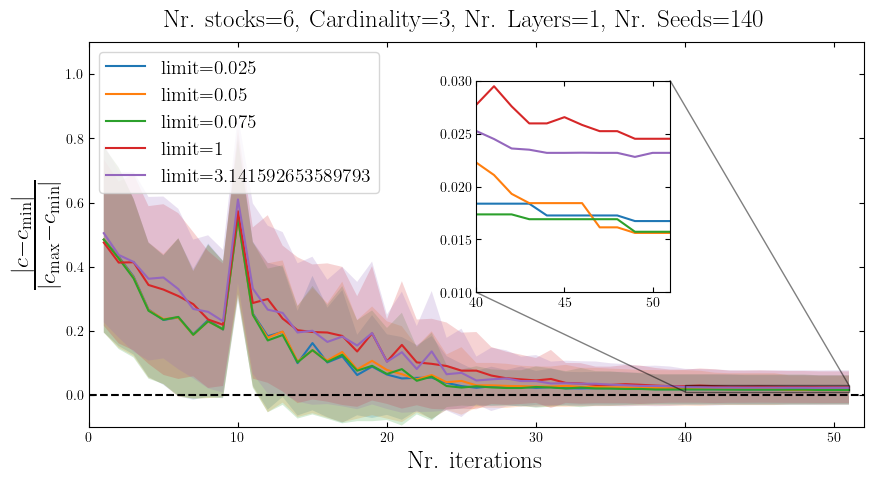

In [77]:
X_vals, Y_vals = [], []
for YS in results:
    smallest = np.inf
    for y in YS:
        if len(y) < smallest:
            smallest = len(y)
    updated_YS = []
    for y in YS:
        updated_YS.append(y[:smallest])
    updated_YS = np.array(updated_YS)
    Y_avg = np.mean(updated_YS, axis=0)
    Y_std = np.std(updated_YS, axis=0)
    X = [it + 1 for it in range(len(Y_avg))]
    X_vals.append(X)
    Y_vals.append((Y_avg, Y_std))

fig, ax = plt.subplots(1,1,figsize=(10,5))
fig.suptitle(f'Nr. stocks={N},  Cardinality={k},  Nr. Layers={layers},  Nr. Seeds={N_SEEDS}', y=0.945, fontsize=18)
ax.set_xlim(0,len(Y_vals[0][0])+1)
ax.set_ylim(-0.1,1.1)
ax.hlines(0,0,len(Y_vals[0][0])+1,ls='--',color='k')

axins_x_left, axins_y_lower, axins_x_width, axins_height = 0.5, 0.35, 0.25, 0.55
axins = ax.inset_axes([axins_x_left, axins_y_lower, axins_x_width, axins_height])

counter = 0
for (Y_avg, Y_std), X in zip(Y_vals, X_vals):
    ax.plot(X, Y_avg, label=r'limit='+f'{scalings[counter]}')
    ax.fill_between(X, Y_avg-Y_std, Y_avg+Y_std, alpha=0.2)
    axins.plot(X, Y_avg)
    counter += 1
    
# sub region of the original image
x1, x2, y1, y2 = 40, 51, 0.01, 0.03
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
ax.indicate_inset_zoom(axins, edgecolor="black")

ax.set_xlabel('Nr. iterations', fontsize=18)
ax.set_ylabel(r'$\frac{|c-c_{\textrm{min}}|}{|c_{\textrm{max}}-c_{\textrm{min}}|}$', fontsize=24)
ax.legend(fontsize=14)

plt.savefig('plots/initialization_comparison_2.png', dpi=300)
plt.show()


# Uniform vs. Gaussian sampling

In [7]:
# General settings:
N=10
k=5
alpha=0.001
layers=4
max_iter=350
w_z_phase = False
w_next_nearest_neighbors = True
w_evenly_distributed = True
method='COBYLA'
sampling_method_1 = 'uniform'
scaling_1 = 0.075

sampling_method_2 = 'gaussian'
scaling_2 = 0.05


# Number of runs:
N_SEEDS = (N_CPU_CORES-1)*1
datapoint_sets = []

set_1 = []
for seed in range(N_SEEDS):
    set_1.append((seed,N,k,alpha,layers,max_iter,w_z_phase,w_next_nearest_neighbors,w_evenly_distributed,method,scaling_1,sampling_method_1))
datapoint_sets.append(set_1)

set_2 = []
for seed in range(N_SEEDS):
    set_2.append((seed,N,k,alpha,layers,max_iter,w_z_phase,w_next_nearest_neighbors,w_evenly_distributed,method,scaling_2,sampling_method_2))
datapoint_sets.append(set_2)

N_jobs = N_CPU_CORES-1
results = []
for datapoint_set in datapoint_sets:
    YS = Parallel(n_jobs=N_jobs, verbose=51, backend='loky')(delayed(simulate)(datapoint) for datapoint in datapoint_set)
    results.append(YS)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   1 tasks      | elapsed:  3.3min
[Parallel(n_jobs=15)]: Done   2 out of  15 | elapsed:  3.3min remaining: 21.6min
[Parallel(n_jobs=15)]: Done   3 out of  15 | elapsed:  3.3min remaining: 13.3min
[Parallel(n_jobs=15)]: Done   4 out of  15 | elapsed:  3.3min remaining:  9.2min
[Parallel(n_jobs=15)]: Done   5 out of  15 | elapsed:  3.3min remaining:  6.7min
[Parallel(n_jobs=15)]: Done   6 out of  15 | elapsed:  3.3min remaining:  5.0min
[Parallel(n_jobs=15)]: Done   7 out of  15 | elapsed:  3.3min remaining:  3.8min
[Parallel(n_jobs=15)]: Done   8 out of  15 | elapsed:  3.3min remaining:  2.9min
[Parallel(n_jobs=15)]: Done   9 out of  15 | elapsed:  3.3min remaining:  2.2min
[Parallel(n_jobs=15)]: Done  10 out of  15 | elapsed:  3.3min remaining:  1.7min
[Parallel(n_jobs=15)]: Done  11 out of  15 | elapsed:  3.3min remaining:  1.2min
[Parallel(n_jobs=15)]: Done  12 out of  15 | elapse

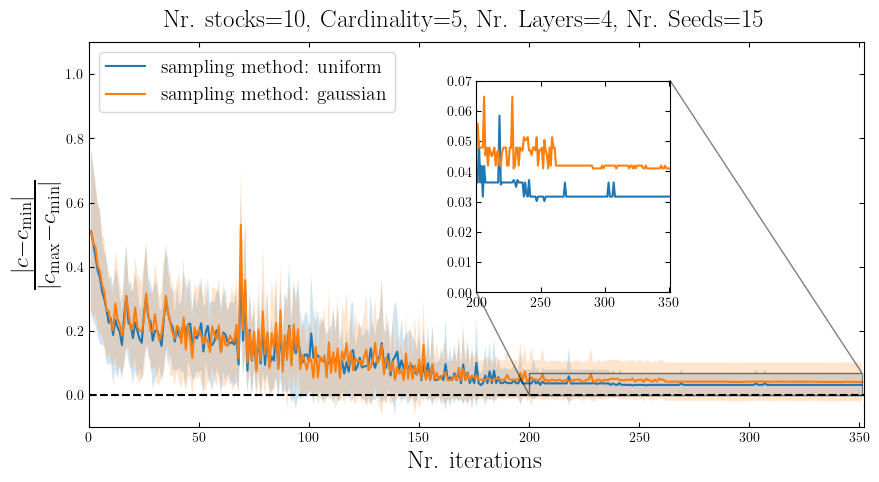

In [11]:
X_vals, Y_vals = [], []
for YS in results:
    smallest = np.inf
    for y in YS:
        if len(y) < smallest:
            smallest = len(y)
    updated_YS = []
    for y in YS:
        updated_YS.append(y[:smallest])
    updated_YS = np.array(updated_YS)
    Y_avg = np.mean(updated_YS, axis=0)
    Y_std = np.std(updated_YS, axis=0)
    X = [it + 1 for it in range(len(Y_avg))]
    X_vals.append(X)
    Y_vals.append((Y_avg, Y_std))

fig, ax = plt.subplots(1,1,figsize=(10,5))
fig.suptitle(f'Nr. stocks={N},  Cardinality={k},  Nr. Layers={layers},  Nr. Seeds={N_SEEDS}', y=0.945, fontsize=18)
ax.set_xlim(0,len(Y_vals[0][0])+1)
ax.set_ylim(-0.1,1.1)
ax.hlines(0,0,len(Y_vals[0][0])+1,ls='--',color='k')

axins_x_left, axins_y_lower, axins_x_width, axins_height = 0.5, 0.35, 0.25, 0.55
axins = ax.inset_axes([axins_x_left, axins_y_lower, axins_x_width, axins_height])

sampling_methods = [sampling_method_1, sampling_method_2]
counter = 0
for (Y_avg, Y_std), X in zip(Y_vals, X_vals):
    ax.plot(X, Y_avg, label=r'sampling method: ' + f'{sampling_methods[counter]}')
    ax.fill_between(X, Y_avg-Y_std, Y_avg+Y_std, alpha=0.2)
    axins.plot(X, Y_avg)
    counter += 1
    
# sub region of the original image
x1, x2, y1, y2 = 200, 351, 0.0, 0.07
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
ax.indicate_inset_zoom(axins, edgecolor="black")

ax.set_xlabel('Nr. iterations', fontsize=18)
ax.set_ylabel(r'$\frac{|c-c_{\textrm{min}}|}{|c_{\textrm{max}}-c_{\textrm{min}}|}$', fontsize=24)
ax.legend(fontsize=14)

plt.savefig('plots/sampling_comparison.png', dpi=300)
plt.show()
